<a href="https://colab.research.google.com/github/JinaniSooriyaarachchi/VisionWithLostGlasses/blob/main/Vision_with_Lost_Glasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_intermediate_layer_getter --quiet
!pip install Pillow --quiet

# Imports
import random
import time

import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from shutil import copyfile, rmtree
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
# For getting output of intermediate layers in Pytorch
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
# For interactive visualization
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms

In [ ]:
# Helpers functions
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


In [ ]:
#  Download Cleaned Data
import os, zipfile, requests

filenames = ["catvdog_clear.zip",
             "catvdog_blur_2.zip",
             "catvdog_blur_5.zip"]

urls = ["https://osf.io/hj2gd/download",
        "https://osf.io/xp6qd/download",
        "https://osf.io/wj43a/download"]
for fname, url in zip(filenames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

for fname in filenames:
  zip_ref = zipfile.ZipFile(fname, 'r')
  zip_ref.extractall()
  zip_ref.close()
  os.remove(fname)

In [ ]:
# Define Preprocessing Filters
preprocessing = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))])

# Create Clean Training Dataset using ImageFolder
clear_train_data = torchvision.datasets.ImageFolder(
    root="dataset/train",
    transform=preprocessing
)

# Create Clean Test Dataset using ImageFolder
clear_test_data = torchvision.datasets.ImageFolder(
    root="dataset/test",
    transform=preprocessing
)

# Create Noisy Training Dataset using ImageFolder
noisy_train_data = torchvision.datasets.ImageFolder(
    root="dataset_blur_5/train",
    transform=preprocessing
)

# Create Noisy Test Dataset using ImageFolder
noisy_test_data = torchvision.datasets.ImageFolder(
    root="dataset_blur_5/test",
    transform=preprocessing
)

# function to apply a training-validation set split on a dataset
def validation_split(train_data, val_ratio = 0.2):
  train_indices, val_indices, _, _ = train_test_split(range(len(train_data)),
                                                      train_data.targets,
                                                      stratify=train_data.targets,
                                                      test_size=val_ratio)
  train_split = torch.utils.data.Subset(train_data, train_indices)
  val_split = torch.utils.data.Subset(train_data, val_indices)
  return train_split,val_split

# Define Batch Size
batch_size = 128

# Define Dataloaders for Training, Validation and Test sets
clear_train_split,clear_val_split = validation_split(clear_train_data)
clear_train_batches = torch.utils.data.DataLoader(clear_train_split,
                                                  batch_size=batch_size,
                                                  shuffle=True)
clear_val_batches = torch.utils.data.DataLoader(clear_val_split,
                                                batch_size=batch_size,
                                                shuffle=True)
clear_test_batches = torch.utils.data.DataLoader(clear_test_data,
                                                 batch_size=batch_size,
                                                 shuffle=True)

noisy_train_split,noisy_val_split = validation_split(noisy_train_data)
noisy_train_batches = torch.utils.data.DataLoader(noisy_train_split,
                                                  batch_size=batch_size,
                                                  shuffle=True)
noisy_val_batches = torch.utils.data.DataLoader(noisy_val_split,
                                                batch_size=batch_size,
                                                shuffle=True)
noisy_test_batches = torch.utils.data.DataLoader(noisy_test_data,
                                                 batch_size=batch_size,
                                                 shuffle=True)

In [ ]:
# Get an example of a clear and noisy versions of cat and dog image
clear_cat_image = clear_train_data[5][0].unsqueeze(0)
clear_dog_image = clear_train_data[19997][0].unsqueeze(0) #clear_train_data[x][1] is the label 1 for dog, 0 for cat
noisy_cat_image = noisy_train_data[5][0].unsqueeze(0) #noisy_train_data=22442
noisy_dog_image = noisy_train_data[19997][0].unsqueeze(0) #noisy_test_data=2494

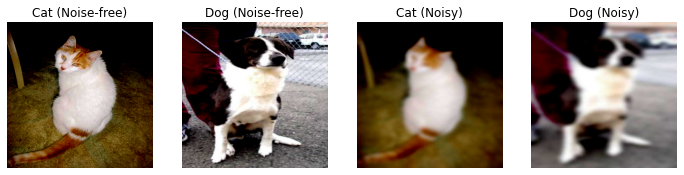

In [ ]:
fig = plt.figure(figsize=(12, 3))
ax=fig.add_subplot(141)
ax.imshow(clear_cat_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Cat (Noise-free)')
ax=fig.add_subplot(142)
ax.imshow(clear_dog_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Dog (Noise-free)')
ax=fig.add_subplot(143)
ax.imshow(noisy_cat_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Cat (Noisy)')
ax=fig.add_subplot(144)
ax.imshow(noisy_dog_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Dog (Noisy)')
plt.show()

In [ ]:
# define function for running some epochs of training
def train(num_epochs, train_batch, val_batch,
          training_losses=None, validation_losses=None, device='gpu'): #Training

  net.train()
  if training_losses is None:
    training_losses = []
  if validation_losses is None:
    validation_losses = []
  for epoch in tqdm.tqdm(range(num_epochs)):
    for batch_idx, (data, target) in enumerate(train_batch):
      data = data.to(device).float()
      target = target.to(device).long()
      # reset the parameter gradients
      optimizer.zero_grad()
      # forward pass + backward pass + optimize
      prediction = net(data)
      loss = criterion(prediction, target)
      loss.backward()
      optimizer.step()
      training_losses += [loss.item()]
    for batch_idx, (data, target) in enumerate(val_batch):
      data = data.to(device).float()
      target = target.to(device).long()
      # forward pass only
      prediction = net(data)
      loss = criterion(prediction, target)
      validation_losses += [loss.item()]
  return training_losses, validation_losses

In [ ]:
# define function to calculate current accuracy with a given dataloader
def accuracy(dataloader, device='gpu'): #Get the accuracies
  net.eval()
  correct = 0
  count = 0
  for data, target in tqdm.tqdm(dataloader):
    data = data.to(device).float()
    target = target.to(device).long()

    prediction = net(data)
    _, predicted = torch.max(prediction, 1)
    count += target.size(0)
    correct += (predicted == target).sum().item()

  acc = 100 * correct / count
  return count, acc


# define function to evaluate and print training and test accuracy
def evaluate(net, device='gpu', title=""):
  net.eval()
  train_count, train_acc_clear = accuracy(clear_train_batches, device=device)
  test_count, test_acc_clear = accuracy(clear_test_batches, device=device)
  print(f'Accuracy on the {train_count} clear training samples {title}: {train_acc_clear:0.2f}')
  print(f'Accuracy on the {test_count} clear testing samples {title}: {test_acc_clear:0.2f}')
  train_count, train_acc_noisy = accuracy(noisy_train_batches, device=device)
  test_count, test_acc_noisy = accuracy(noisy_test_batches, device=device)
  print(f'Accuracy on the {train_count} blurry training samples {title}: {train_acc_noisy:0.2f}')
  print(f'Accuracy on the {test_count} blurry testing samples {title}: {test_acc_noisy:0.2f}')

  return train_acc_clear,test_acc_clear,train_acc_noisy,test_acc_noisy

In [ ]:
# import alexnet with pretrained "false"
import torchvision.models as models
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)

# Define network, loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
net.to(DEVICE)

# Evaluate before training
train_acc_clear_NaiveBefore,test_acc_clear_NaiveBefore,train_acc_noisy_NaiveBefore,test_acc_noisy_NaiveBefore=evaluate(net, device=DEVICE, title="before training")

# Define number of epochs
num_training_epochs = 1

# Save network weights
torch.save(net.state_dict(), "naive_before_training")

# Training loop
naive_training_losses, naive_validation_losses = train(num_training_epochs,
                                                       noisy_train_batches,
                                                       noisy_val_batches,
                                                       device=DEVICE)

# Save network weights
torch.save(net.state_dict(), "naive_after_training")

# Evaluate after training
train_acc_clear_NaiveAfter,test_acc_clear_NaiveAfter,train_acc_noisy_NaiveAfter,test_acc_noisy_NaiveAfter=evaluate(net, device=DEVICE, title="after training")

"""
# Plot Loss over epochs
plt.figure()
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(naive_training_losses,
                                             num_training_epochs)],
         "o-", label="Training Loss")
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(naive_validation_losses,
                                             num_training_epochs)],
         "o-", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()
"""

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples before training: 50.00
Accuracy on the 2494 clear testing samples before training: 50.00


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples before training: 50.00
Accuracy on the 2494 blurry testing samples before training: 50.00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples after training: 65.74
Accuracy on the 2494 clear testing samples after training: 66.16


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples after training: 65.45
Accuracy on the 2494 blurry testing samples after training: 65.68


'\n# Plot Loss over epochs\nplt.figure()\nplt.plot(np.arange(1, num_epochs + 1),\n         [np.mean(x) for x in np.array_split(naive_training_losses,\n                                             num_training_epochs)],\n         "o-", label="Training Loss")\nplt.plot(np.arange(1, num_epochs + 1),\n         [np.mean(x) for x in np.array_split(naive_validation_losses,\n                                             num_training_epochs)],\n         "o-", label="Validation Loss")\nplt.xlabel("Epochs")\nplt.ylabel("Cross Entropy Loss")\nplt.legend()\nplt.show()\n'

In [ ]:
# import alexnet with pretrained "false"
import torchvision.models as models
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)

# Define network, loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
net.to(DEVICE)

## Evaluate before training
#evaluate(net, device=DEVICE, title="before training")

# Define number of epochs
num_training_epochs = 1

# Save network weights
#torch.save(net.state_dict(), "expert_before_training")

# Training loop
naive_training_losses, naive_validation_losses = train(num_training_epochs, #train on clean data and test on both
                                                       clear_train_batches,
                                                       clear_val_batches,
                                                       device=DEVICE)

# Save network weights
torch.save(net.state_dict(), "expert_before_training")

# Evaluate after training
train_acc_clear_ExpertBefore,test_acc_clear_ExpertBefore,train_acc_noisy_ExpertBefore,test_acc_noisy_ExpertBefore=evaluate(net, device=DEVICE, title="after training")

"""
# Plot Loss over epochs
plt.figure()
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(naive_training_losses,
                                             num_training_epochs)],
         "o-", label="Training Loss")
plt.plot(np.arange(1, num_epochs + 1),
         [np.mean(x) for x in np.array_split(naive_validation_losses,
                                             num_training_epochs)],
         "o-", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()
"""

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples after training: 64.85
Accuracy on the 2494 clear testing samples after training: 64.72


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples after training: 52.88
Accuracy on the 2494 blurry testing samples after training: 53.09


'\n# Plot Loss over epochs\nplt.figure()\nplt.plot(np.arange(1, num_epochs + 1),\n         [np.mean(x) for x in np.array_split(naive_training_losses,\n                                             num_training_epochs)],\n         "o-", label="Training Loss")\nplt.plot(np.arange(1, num_epochs + 1),\n         [np.mean(x) for x in np.array_split(naive_validation_losses,\n                                             num_training_epochs)],\n         "o-", label="Validation Loss")\nplt.xlabel("Epochs")\nplt.ylabel("Cross Entropy Loss")\nplt.legend()\nplt.show()\n'

In [ ]:
# Training loop
experienced_training_losses, experienced_validation_losses = train(num_training_epochs,
                                                                   noisy_train_batches,
                                                                   noisy_val_batches,
                                                                   device=DEVICE)

# Save network weights
torch.save(net.state_dict(), "expert_after_training")

# Evaluate after training
train_acc_clear_ExpertAfter,test_acc_clear_ExpertAfter,train_acc_noisy_ExpertAfter,test_acc_noisy_ExpertAfter=evaluate(net, device=DEVICE, title="after training")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 clear training samples after training: 70.22
Accuracy on the 2494 clear testing samples after training: 70.13


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy on the 17953 blurry training samples after training: 66.54
Accuracy on the 2494 blurry testing samples after training: 66.92


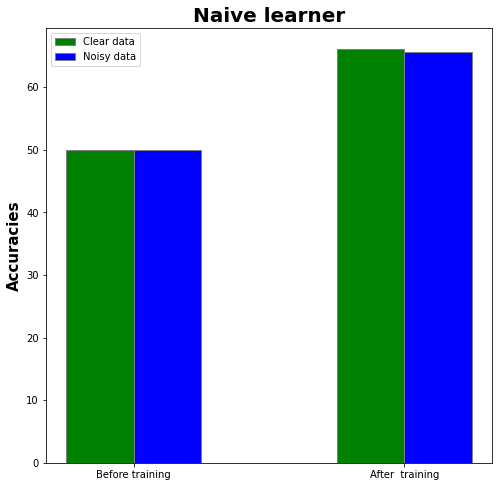

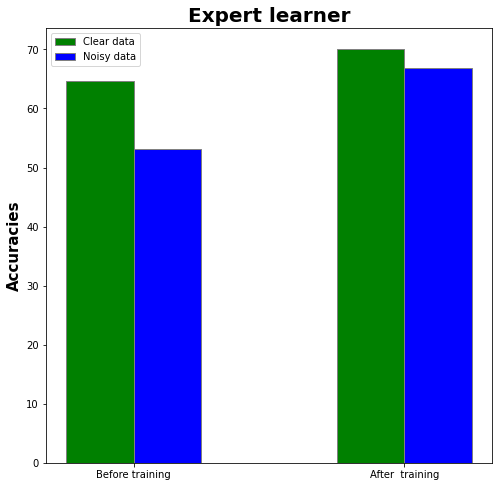

'\nplt.plot()\nplt.bar([[clear_test_accuracies,noisy_test_accuracies]],label=[\'Accuarcy on Clear images\',\'Accuarcy on Noisy images\'])\nplt.legend(loc=\'upper right\')\nplt.title("Naive training on noisy data")\nplt.ylabel("Accuracy")\nplt.show()\n\nclear_test_accuracies=[test_acc_clear_ExpertBefore,test_acc_clear_ExpertAfter]\nnoisy_test_accuracies=[test_acc_noisy_ExpertBefore,test_acc_noisy_ExpertAfter]\nplt.plot()\nplt.bar([clear_test_accuracies,noisy_test_accuracies],label=[\'Accuarcy on Clear images\',\'Accuarcy on Noisy images\'])\nplt.legend(loc=\'upper right\')\nplt.title("Naive training on noisy data")\nplt.ylabel("Accuracy")\nplt.show()\n'

In [ ]:
# compare the accuracies of naive and expert learner before and after training


barWidth = 0.25
fig = plt.subplots(figsize =(8, 8))
clear_test_accuracies=[test_acc_clear_NaiveBefore,test_acc_clear_NaiveAfter]
noisy_test_accuracies=[test_acc_noisy_NaiveBefore,test_acc_noisy_NaiveAfter]
br1 = np.arange(len(clear_test_accuracies))
br2 = [x + barWidth for x in br1]
 
plt.bar(br1, clear_test_accuracies, color ='g', width = barWidth,
        edgecolor ='grey', label ='Clear data')
plt.bar(br2, noisy_test_accuracies, color ='b', width = barWidth,
        edgecolor ='grey', label ='Noisy data')
plt.ylabel('Accuracies', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(clear_test_accuracies))],
        ['Before training', 'After  training'])
plt.title('Naive learner', fontweight ='bold', fontsize = 20)
plt.legend()
plt.show()



fig = plt.subplots(figsize =(8, 8))
clear_test_accuracies=[test_acc_clear_ExpertBefore,test_acc_clear_ExpertAfter]
noisy_test_accuracies=[test_acc_noisy_ExpertBefore,test_acc_noisy_ExpertAfter]
plt.bar(br1, clear_test_accuracies, color ='g', width = barWidth,
        edgecolor ='grey', label ='Clear data')
plt.bar(br2, noisy_test_accuracies, color ='b', width = barWidth,
        edgecolor ='grey', label ='Noisy data')
plt.ylabel('Accuracies', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(clear_test_accuracies))],
        ['Before training', 'After  training'])
plt.title('Expert learner', fontweight ='bold', fontsize = 20)
plt.legend()
plt.show()


#**Results**
#### Naive learner before training on noisy data performs with an accuracy of 50%. However, after training on noisy data, the accuracy on both clear and noisy data are ~65%.
#### Expert learner who was already trained on clear data has an accuracy of 64% on clear data but ony 53% on noisy data. After training this expert learner on noisy data has an accuracy of 70% on clear data and 66% on noisy data. This is very similar to the accuracy with noisy data of the naive learner.

#### Overall, a naive learner performs with an accuracy of 65% after learning only on the noisy images. The expert learner (trained on clear data before) initially performs only with 53% accuracy and even after learning with noisy images, will not perform better than the naive learner (only 66% compared to 65%). Therefore expert learner suffers classifying noisy images.

In [51]:
# choose intermidiate layers from which to get the output
return_layers = {
    'features.2': 'conv1',
    'features.5': 'conv2',
    'features.7': 'conv3',
    'features.9': 'conv4',
    'features.12': 'conv5',
    }

def plot_intermediate_layers(image, net, return_layers=return_layers):
  # Get output for the image from the intermediate layers
  intermediate_output = LayerGetter(net, return_layers=return_layers)(image)
  fig = plt.figure(figsize=(12, 3))
  ax=fig.add_subplot(141)
  ax.imshow(image.squeeze(0).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Original Image')
  ax=fig.add_subplot(142)
  ax.imshow(intermediate_output[0]['conv1'].detach().cpu().squeeze(0).mean(axis=0))
  plt.axis('off')
  plt.title('V1 layer (Average)')
  ax=fig.add_subplot(143)
  ax.imshow(intermediate_output[0]['conv2'].detach().cpu().squeeze(0).mean(axis=0))
  plt.axis('off')
  plt.title('V2 layer (Average)')
  ax=fig.add_subplot(144)
  ax.imshow(intermediate_output[0]['conv5'].detach().cpu().squeeze(0).mean(axis=0))
  plt.axis('off')
  plt.title('V4 layer (Average)')
  plt.show()

Naive Model
Before Training


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


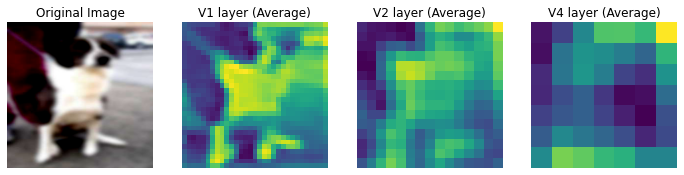

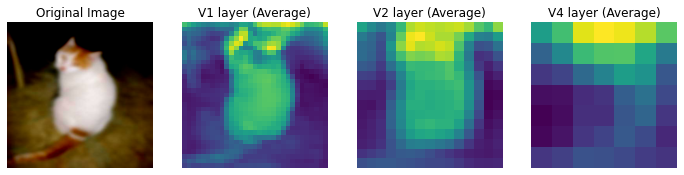

After Training


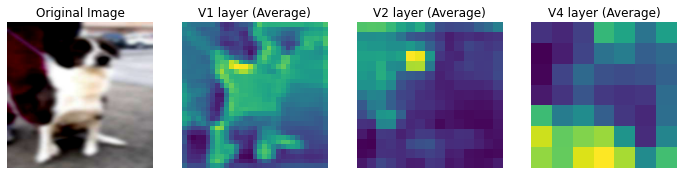

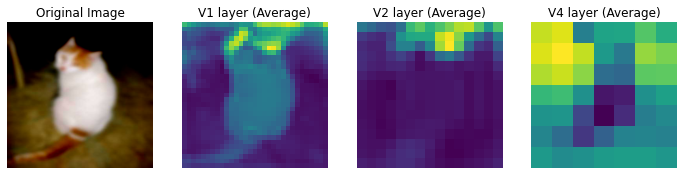

In [52]:
# examining the learned features 

print("Naive Model\n=============")
print("Before Training")

net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
# Load and assign previous state
net.load_state_dict(torch.load('naive_before_training'))
plot_intermediate_layers(noisy_dog_image, net)
plot_intermediate_layers(noisy_cat_image, net)

print("After Training")
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
# Load and assign previous state
net.load_state_dict(torch.load('naive_after_training'))
plot_intermediate_layers(noisy_dog_image, net)
plot_intermediate_layers(noisy_cat_image, net)

Expert Model
After Pretraining


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


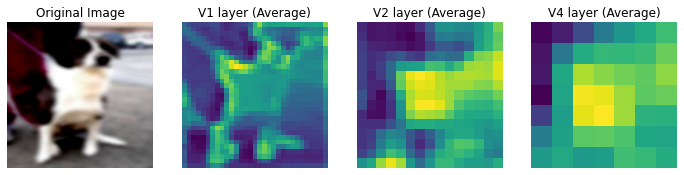

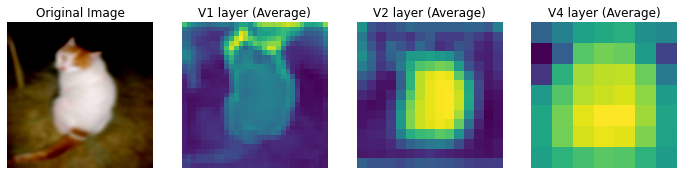

After Training


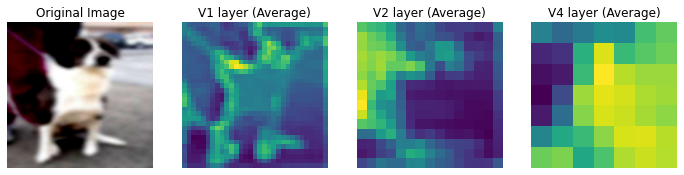

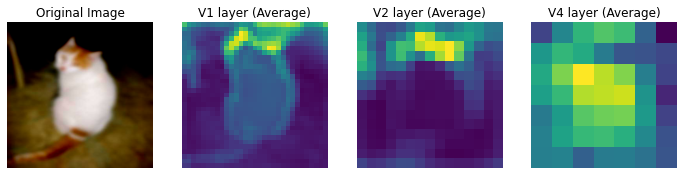

In [54]:
print("Expert Model\n=============")

print("After Pretraining")
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
# Load and assign previous state
net.load_state_dict(torch.load('expert_before_training'))
plot_intermediate_layers(noisy_dog_image,net)
plot_intermediate_layers(noisy_cat_image,net)

print("After Training")
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
# Load and assign previous state
net.load_state_dict(torch.load('expert_after_training'))
plot_intermediate_layers(noisy_dog_image,net)
plot_intermediate_layers(noisy_cat_image,net)